In [1]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

# Graph Auto Encoders and Variational Graph Auto Encoders

This is a test notebook to understand the functioning of graph auto encoders and variational graph auto encoders

#### Graph Auto encoders

How it works? Just like in a normal auto encoder, what happens is that input is first downsized through a couple of Conv layers and then upscaled back. It has 3 components Encoder -> Embedding space -> Decoder.

Similarly a Graph Auto Encoder will have autoencoders for every node present. The node will have its own features and it will be forward to auto encoder. The decoders will use the adjacent embeddings to decode the embedding space.

In [3]:
dataset = Planetoid('data','CiteSeer',transform=T.NormalizeFeatures())
dataset.data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [4]:
data = dataset[0]

data.train_mask = data.val_mask = data.test_mask = None
data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327])

In [5]:
data = train_test_split_edges(data)

C:\Users\msadi\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [6]:
data

Data(x=[3327, 3703], y=[3327], val_pos_edge_index=[2, 227], test_pos_edge_index=[2, 455], train_pos_edge_index=[2, 7740], train_neg_adj_mask=[3327, 3327], val_neg_edge_index=[2, 227], test_neg_edge_index=[2, 455])

### Define the Encoder

In [7]:
class GCNEncoder(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super(GCNEncoder,self).__init__()
        self.conv1 = GCNConv(in_channels,256,cached = True)  # cached only for transductive learning
        self.conv1_5 = GCNConv(512,128,cached=True)         # cached only for transductive learning
        self.conv2 = GCNConv(128,out_channels,cached=True) # cached only for transductive learning
        
    def forward(self,x,edge_index):
        x = self.conv1(x,edge_index).relu()
        x = self.conv1_5(x,edge_index).relu()
        return self.conv2(x,edge_index)

### Define the AutoEncoder

In [8]:
from torch_geometric.nn import GAE

In [16]:
# parameters
out_channels = 32
num_features = dataset.num_features
epochs = 1000

# model

model = GAE(GCNEncoder(num_features,out_channels))

# move to device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)


In [17]:
def train(model, optimizer, x, pos_edge):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x,pos_edge)
    loss = model.recon_loss(z, pos_edge)
    loss.backward()
    optimizer.step()
    return float(loss)

def test(pos_edge,neg_edge,x,train_pos_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x,train_pos_index)
    return model.test(z,pos_edge,neg_edge)

In [20]:
history={'auc':[],'ap':[]}

for epoch in range(1,epochs+1):
    loss = train(model,optimizer,x,train_pos_edge_index)
    
    auc,ap = test(data.test_pos_edge_index,data.test_neg_edge_index,x,train_pos_edge_index)
    history['auc'].append(auc)
    history['ap'].append(ap)
    if epoch%100==0:
        print("Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}".format(epoch,auc,ap))
    

Epoch: 100, AUC: 0.8811, AP: 0.8999
Epoch: 200, AUC: 0.8779, AP: 0.8990
Epoch: 300, AUC: 0.8726, AP: 0.8964
Epoch: 400, AUC: 0.8731, AP: 0.8967
Epoch: 500, AUC: 0.8746, AP: 0.8979
Epoch: 600, AUC: 0.8728, AP: 0.8966
Epoch: 700, AUC: 0.8671, AP: 0.8917
Epoch: 800, AUC: 0.8668, AP: 0.8905
Epoch: 900, AUC: 0.8626, AP: 0.8887
Epoch: 1000, AUC: 0.8639, AP: 0.8882


In [21]:
import matplotlib.pyplot as plt

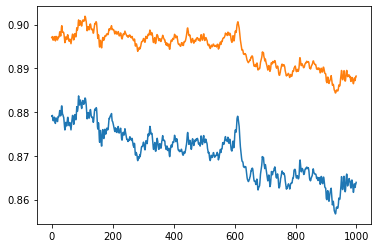

In [24]:
plt.plot(history['auc'])
plt.plot(history['ap'])
plt.show()

# TensorBoard

for live monitoring of the model performance

In [25]:
from torch.utils.tensorboard import SummaryWriter

In [26]:
# parameters
out_channels = 32
num_features = dataset.num_features
epochs = 1000

# model

model = GAE(GCNEncoder(num_features,out_channels))

# move to device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)


### Import TensorBoard

In [27]:
writer = SummaryWriter('runs/GAE_experiment_'+'32d_1000_epochs')

In [29]:

for epoch in range(1,epochs+1):
    loss = train(model,optimizer,x,train_pos_edge_index)
    
    auc,ap = test(data.test_pos_edge_index,data.test_neg_edge_index,x,train_pos_edge_index)
    if epoch%100==0:
        print("Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}".format(epoch,auc,ap))
    writer.add_scalar('auc train',auc,epoch)
    writer.add_scalar('ap train',ap,epoch)

Epoch: 100, AUC: 0.8902, AP: 0.8890
Epoch: 200, AUC: 0.8844, AP: 0.8880
Epoch: 300, AUC: 0.8834, AP: 0.8995
Epoch: 400, AUC: 0.8870, AP: 0.9029
Epoch: 500, AUC: 0.8885, AP: 0.9058
Epoch: 600, AUC: 0.8930, AP: 0.9099
Epoch: 700, AUC: 0.8984, AP: 0.9128
Epoch: 800, AUC: 0.8931, AP: 0.9092
Epoch: 900, AUC: 0.8984, AP: 0.9114
Epoch: 1000, AUC: 0.8934, AP: 0.9074
